<a href="https://colab.research.google.com/github/florian-frey/AudioSimilarity/blob/main/src/Model_Evaluation_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Setup

In [1]:
# !pip uninstall tensorflow
# !pip install tensorflow==2.13

In [2]:
import tensorflow as tf
tf.__version__
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

## 1.1 Copy Data

In [3]:
# connect to google drive --> allows to store kaggle.json API token under the main folder in the drive,
#   so that it doesn't have to be uploaded every time
# Alternatively the kaggle.json can be uploaded under /content/

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DATA_DIR = "/content/data/"
if not os.path.exists(DATA_DIR):
  shutil.copytree("/content/drive/MyDrive/SpectrogramsASS/", DATA_DIR)

## 1.2 Load Dataset

In [5]:
# configuration
VAL_SIZE = 0.2
TEST_SIZE = 0.2
IMG_HEIGHT = 224
IMG_WIDTH = 224
batch_size = 16
# NUM_CHANNELS has to be 3 for "rgb" and 1 for "grayscale"
NUM_CHANNELS = 1

In [6]:
# load the training data set as rgb images
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=VAL_SIZE+TEST_SIZE,
  label_mode="categorical",
  subset="training",
  color_mode="grayscale",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=batch_size)

# load validation data set
val_test_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=VAL_SIZE+TEST_SIZE,
  label_mode="categorical",
  subset="validation",
  color_mode="grayscale",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=batch_size)

Found 7916 files belonging to 8 classes.
Using 4750 files for training.
Found 7916 files belonging to 8 classes.
Using 3166 files for validation.


In [7]:
# store class names
CLASS_NAMES = train_ds.class_names
CLASS_NAMES

['Electronic',
 'Experimental',
 'Folk',
 'Hip-Hop',
 'Instrumental',
 'International',
 'Pop',
 'Rock']

In [8]:
# split validation data set in val_ds and test_ds
val_batches = len(val_test_ds)
test_ds = val_test_ds.take(val_batches // 2)
val_ds = val_test_ds.skip(val_batches // 2)

# count number of batches in training, validation and test dataset
print(f"""The dataset is distributed in :
  - {len(train_ds)} Batches for training
  - {len(test_ds)} Batches for testing
  - {len(val_ds)} Batches for validation with each {batch_size} images per Batch
      """)

The dataset is distributed in :
  - 297 Batches for training
  - 99 Batches for testing
  - 99 Batches for validation with each 16 images per Batch
      


In [9]:
def create_and_scale_images(datasets: list):
  images = np.array([])
  labels =  np.array([])
  for dataset in datasets:
    for batch, label in dataset:
        if len(images)==0:
            images = batch.numpy()
        else:
            images = np.concatenate([images, batch.numpy()])
        labels = np.concatenate([labels, np.argmax(label.numpy(), axis=-1)])
  # scale
  images /= 255.
  return images, labels

In [11]:
images, labels = create_and_scale_images([train_ds, val_ds])
test_images, test_labels = create_and_scale_images([test_ds])

In [12]:
images.shape, test_images.shape

((6332, 224, 224, 1), (1584, 224, 224, 1))

# 2 Load models and encode/decode data

In [15]:
n_data = len(test_images) # 500 # max = len(images)

In [16]:
encoder_v1 = tf.keras.saving.load_model("/content/drive/MyDrive/ASSModel/AEv1encoder")
decoder_v1 = tf.keras.saving.load_model("/content/drive/MyDrive/ASSModel/AEv1decoder")
encoder_v2 = tf.keras.saving.load_model("/content/drive/MyDrive/ASSModel/VAEv2encoder")
decoder_v2 = tf.keras.saving.load_model("/content/drive/MyDrive/ASSModel/VAEv2decoder")
encoder_v3 = tf.keras.saving.load_model("/content/drive/MyDrive/ASSModel/AEv3encoder")
decoder_v3 = tf.keras.saving.load_model("/content/drive/MyDrive/ASSModel/AEv3decoder")

In [17]:
mean_v1, logvar_v1 = tf.split(encoder_v1.predict(test_images[:n_data,:,:]), num_or_size_splits=2, axis=1)
eps = tf.random.normal(shape=mean_v1.shape)
encoded_v1 = eps * tf.exp(logvar_v1 * .5) + mean_v1

50/50 [==============================] - 20s 399ms/step


In [18]:
# encoded_v1 = np.array(encoder_v1.predict(images[:,:,:]))
mean_v2, logvar_v2, encoded_v2 = np.array(encoder_v2.predict(test_images[:n_data,:,:]))
encoded_v3 = np.array(encoder_v3.predict(test_images[:n_data,:,:]))

50/50 [==============================] - 25s 486ms/step


In [19]:
encoded_v1.shape, encoded_v2.shape, encoded_v3.shape

(TensorShape([1584, 100]), (1584, 100), (1584, 100))

In [20]:
decoded_v1 = decoder_v1.predict(encoded_v1)
decoded_v2 = decoder_v2.predict(encoded_v2)
decoded_v3 = decoder_v3.predict(encoded_v3)
decoded_v1.shape, decoded_v2.shape, decoded_v3.shape

50/50 [==============================] - 96s 2s/step


((1584, 224, 224, 1), (1584, 224, 224, 1), (1584, 224, 224, 1))

# 4 Evaluation of models

## 4.1 Compare decoded images with original

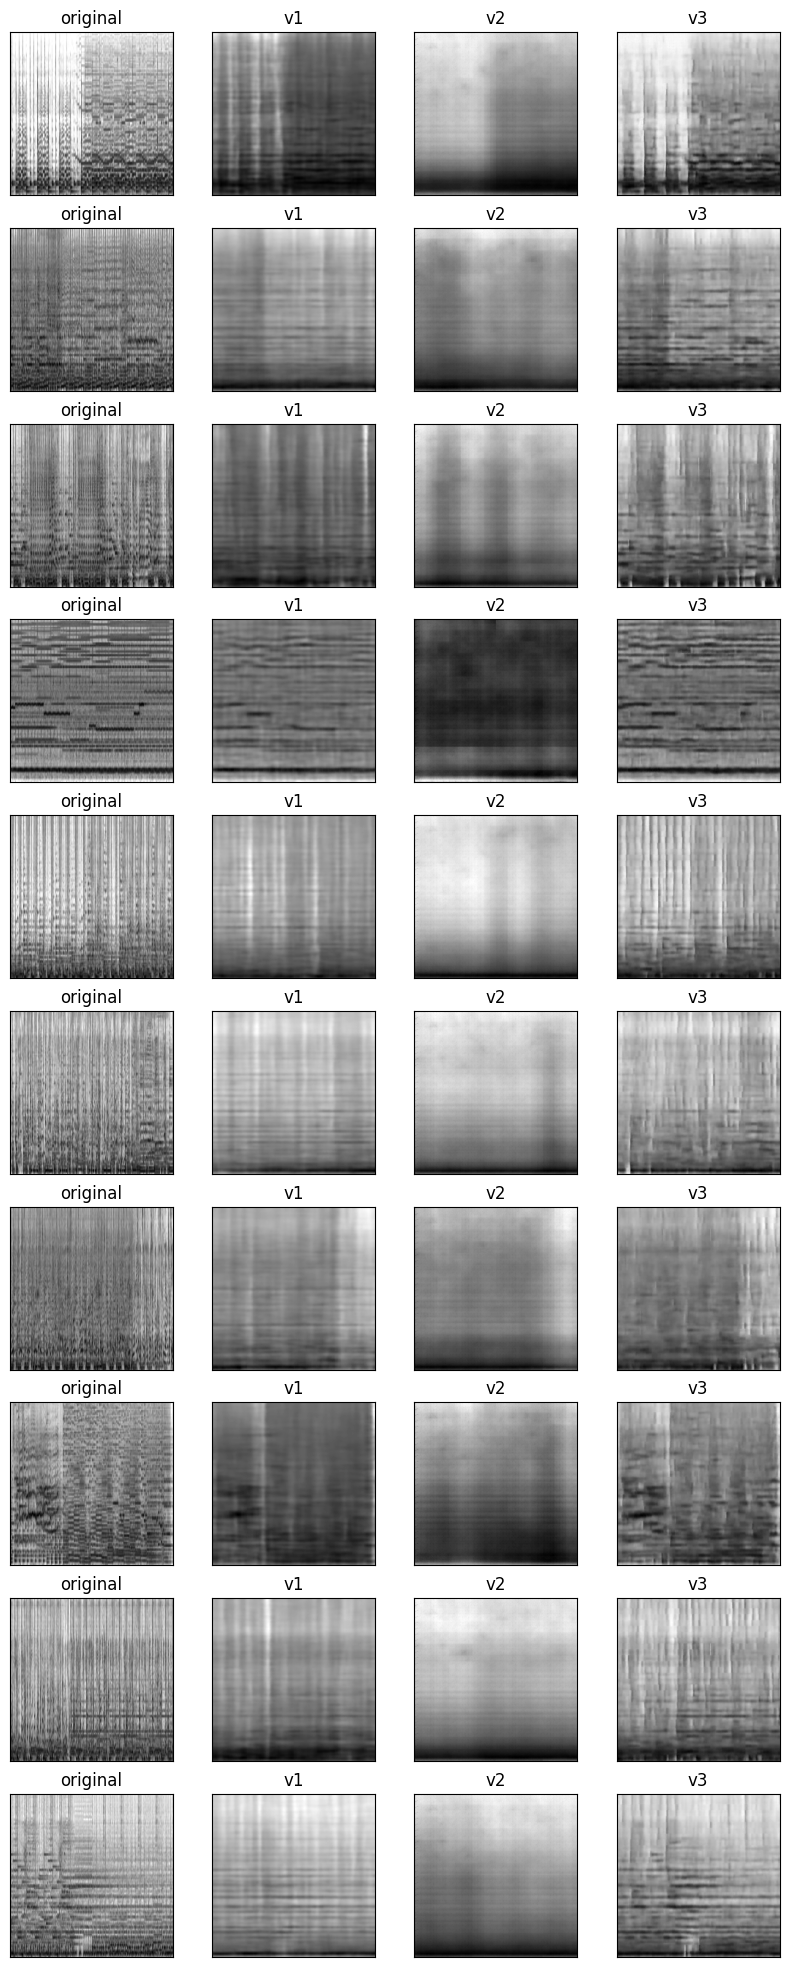

In [ ]:
n = 10
plt.figure(figsize=(10, 25))

for i in range(n):
    # display original
    ax = plt.subplot(n,4,4*i+1)
    plt.imshow(images[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(n,4,4*i+2)
    plt.imshow(decoded_v1[i])
    plt.title("v1")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(n,4,4*i+3)
    plt.imshow(decoded_v2[i])
    plt.title("v2")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(n,4,4*i+4)
    plt.imshow(decoded_v3[i])
    plt.title("v3")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## 4.2 PCA

In [ ]:
PCA_v1 = PCA(n_components=2).fit_transform(encoded_v1)
PCA_v2 = PCA(n_components=2).fit_transform(encoded_v2)
PCA_v3 = PCA(n_components=2).fit_transform(encoded_v3)

In [ ]:
labels = labels[:n_data]

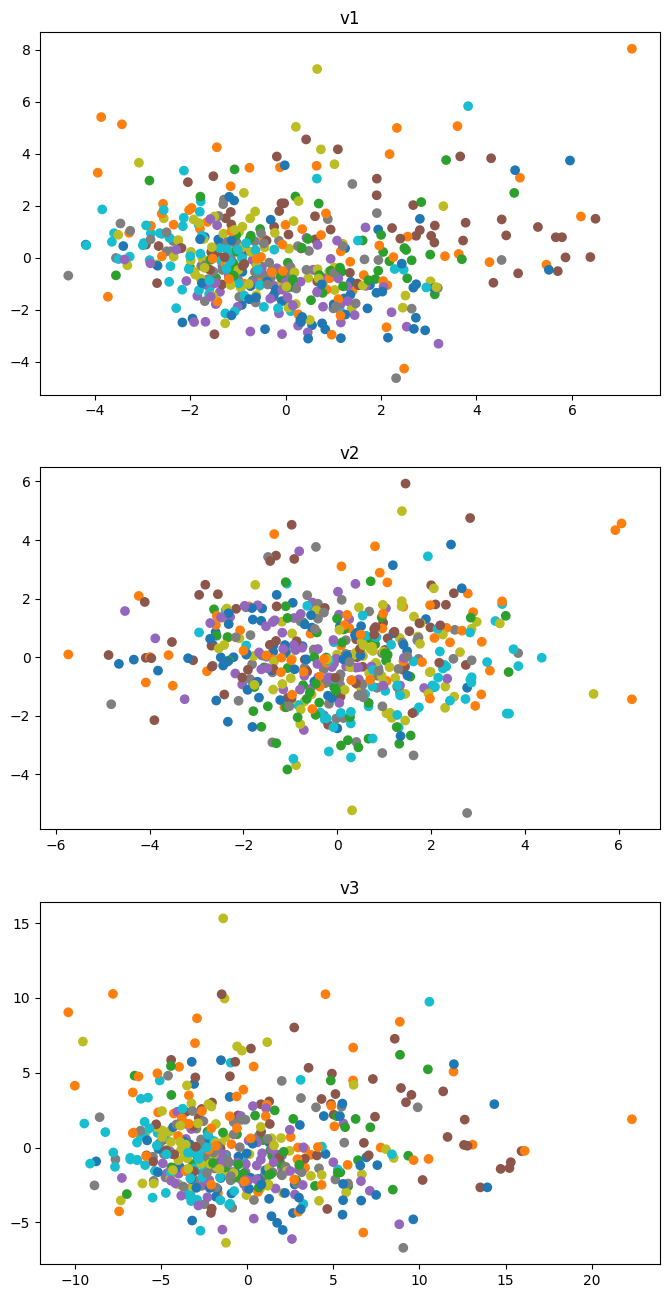

In [ ]:
fig, axs = plt.subplots(3, figsize=(8,16))
axs[0].scatter(PCA_v1[:,0], PCA_v1[:,1], c=labels, cmap="tab10")
axs[0].set_title("v1")
axs[1].scatter(PCA_v2[:,0], PCA_v2[:,1], c=labels, cmap="tab10")
axs[1].set_title("v2")
axs[2].scatter(PCA_v3[:,0], PCA_v3[:,1], c=labels, cmap="tab10")
axs[2].set_title("v3")
plt.show()

## 4.3 TSNE

In [ ]:
LR = "auto"
INIT = "random"
PERPLEXITY = 20
PCA_COMPONENTS = 50

In [ ]:
TSNE_v1 = TSNE(n_components=2, learning_rate=LR, init=INIT, perplexity=PERPLEXITY).fit_transform(PCA(PCA_COMPONENTS).fit_transform(encoded_v1))
TSNE_v2 = TSNE(n_components=2, learning_rate=LR, init=INIT, perplexity=PERPLEXITY).fit_transform(PCA(PCA_COMPONENTS).fit_transform(encoded_v2))
TSNE_v3 = TSNE(n_components=2, learning_rate=LR, init=INIT, perplexity=PERPLEXITY).fit_transform(PCA(PCA_COMPONENTS).fit_transform(encoded_v3))

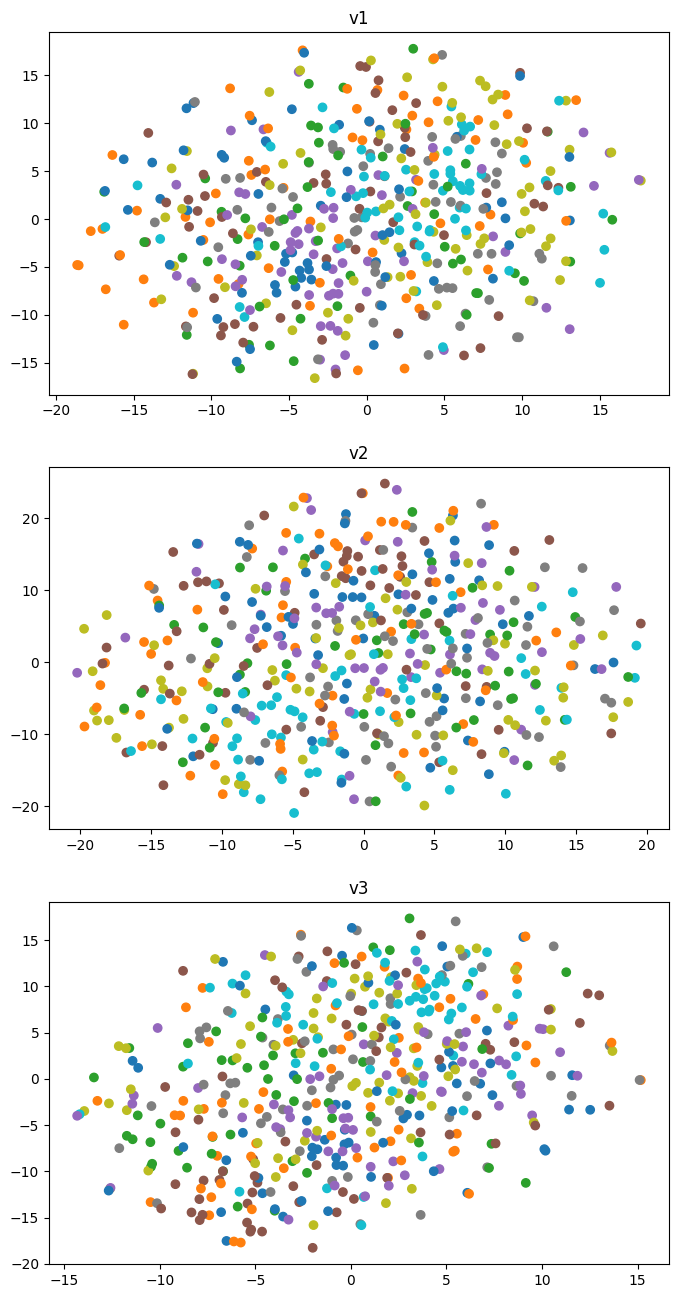

In [ ]:
fig, axs = plt.subplots(3, figsize=(8,16))
axs[0].scatter(TSNE_v1[:,0], TSNE_v1[:,1], c=labels, cmap="tab10")
axs[0].set_title("v1")
axs[1].scatter(TSNE_v2[:,0], TSNE_v2[:,1], c=labels, cmap="tab10")
axs[1].set_title("v2")
axs[2].scatter(TSNE_v3[:,0], TSNE_v3[:,1], c=labels, cmap="tab10")
axs[2].set_title("v3")
plt.show()

In [ ]:
# test = z_TSNEd[np.where((labels == 0) | (labels==2))]
# test_label = labels[np.where((labels == 0) | (labels==2))]

In [ ]:
# plt.scatter(test[:,0], test[:,1], c=test_label, cmap="Accent")

## 4.4 Implementing Kullback Leibler Divergence

In [ ]:
import scipy

### 4.4.1 KL for v1


In [ ]:
kl_v1 = np.array(scipy.special.kl_div(images[:500,:,:], decoded_v1[:500,:,:], out=None))
kl_v1

array([[[[1.3888783e+00],
         [1.6940448e+00],
         [2.1026042e+00],
         ...,
         [4.4154504e-01],
         [4.6799454e-01],
         [2.8355524e-01]],

        [[1.4661820e+00],
         [1.9412853e+00],
         [2.1131134e+00],
         ...,
         [4.3777889e-01],
         [4.5864886e-01],
         [3.5355136e-01]],

        [[1.7292283e+00],
         [1.8518747e+00],
         [2.2440202e+00],
         ...,
         [4.5070750e-01],
         [4.6410564e-01],
         [4.1227120e-01]],

        ...,

        [[1.3241595e-01],
         [1.3541165e-01],
         [1.5605969e-02],
         ...,
         [          inf],
         [          inf],
         [          inf]],

        [[3.3909861e-02],
         [4.9211844e-03],
         [3.8010359e-02],
         ...,
         [          inf],
         [          inf],
         [          inf]],

        [[8.5015520e-02],
         [2.0350641e-02],
         [5.3542729e-02],
         ...,
         [          inf],
        

In [ ]:
kl_v1[kl_v1 == float("inf")] = 0


In [ ]:
kl_v1.max()

12.385387

In [ ]:
kl_v1.shape

(500, 224, 224, 1)

In [ ]:
for i in range (len(kl_v1)):
  print(kl_v1[i].mean())

0.24089332
0.11398836
0.13352355
0.116233274
0.066024706
0.10359383
0.12784858
0.13234474
0.11334435
0.10617254
0.15407789
0.040400676
0.25415164
0.13451326
0.11435206
0.13512006
0.2661344
0.11106733
0.1134787
0.3655212
0.21589264
0.1476122
0.21132971
0.09854111
0.15820442
0.294197
0.1460864
0.06939179
0.07181145
0.20705268
0.19359341
0.10762978
0.16998462
0.14204927
0.17954592
0.12885405
0.09353971
0.11737321
0.1304552
0.11816882
0.05005456
0.094719335
0.44674522
0.11681995
0.1487529
0.12892061
0.09939312
0.14593074
0.1007802
0.12227138
0.21276128
0.07967982
0.13605568
0.11202122
0.1284928
0.24145223
0.1102769
0.11567999
0.11159605
0.17673562
0.8803223
0.04951447
0.17386426
0.15930165
0.42562646
0.8248998
0.12361673
0.05999953
0.08833193
0.044801794
0.17106387
0.1049606
0.14194746
0.14885144
0.081594884
0.20710412
0.24774486
0.31694734
0.07399653
0.045948584
0.18545178
0.18471527
0.1491492
0.09969448
0.17924063
0.19383335
0.06786968
0.099634655
0.14499101
0.101280905
0.17853343
0.0916

In [ ]:
Kl_v1_mean=[]
for i in range (len(kl_v1)):
  Kl_v1_mean.append(kl_v1[i].mean())
np.array(Kl_v1_mean).mean()


0.17243364

### 4.4.2 KL for v2

In [ ]:
kl_v2 = np.array(scipy.special.kl_div(images[:500,:,:], decoded_v2[:500,:,:], out=None))
kl_v2

array([[[[3.27336788e-03],
         [2.47023045e-03],
         [3.98869533e-03],
         ...,
         [5.43956703e-05],
         [1.81433484e-06],
         [3.28559093e-02]],

        [[5.38150547e-04],
         [2.82618625e-04],
         [6.99432893e-03],
         ...,
         [1.37307461e-05],
         [1.61991775e-05],
         [5.50850341e-03]],

        [[1.49785716e-04],
         [6.50339425e-05],
         [5.23126172e-03],
         ...,
         [1.88969774e-04],
         [3.47036894e-06],
         [2.89095705e-03]],

        ...,

        [[1.97955314e-03],
         [6.70363521e-03],
         [8.87351856e-03],
         ...,
         [9.59662357e-05],
         [3.62574845e-03],
         [2.74224319e-02]],

        [[1.04665710e-02],
         [9.50104278e-03],
         [2.61594877e-02],
         ...,
         [1.70246985e-05],
         [2.23268731e-03],
         [3.49960197e-03]],

        [[3.57996114e-02],
         [2.76827589e-02],
         [3.24046835e-02],
         ...,
 

In [ ]:
kl_v2[kl_v2 == float("inf")] = 0

In [ ]:
kl_v2.max()

0.9115114

In [ ]:
for i in range (len(kl_v2)):
  print(kl_v2[i].mean())

0.014431797
0.009817955
0.014135898
0.016701477
0.0127397375
0.012004096
0.009826648
0.013064606
0.012848754
0.0085959025
0.015113131
0.0064476985
0.010924021
0.009117041
0.012166039
0.01467531
0.009006813
0.012979969
0.009728801
0.0075372937
0.008911765
0.015372967
0.013663068
0.007584539
0.016549822
0.006874327
0.0080087995
0.011982752
0.0093249725
0.009893189
0.011001562
0.008361634
0.0098815495
0.017462252
0.014046847
0.008269557
0.007284188
0.012586728
0.008278632
0.0034959756
0.0075899186
0.012732123
0.013970998
0.0075083715
0.014440033
0.0100078015
0.007936182
0.00862561
0.013320585
0.013704418
0.011859072
0.008837723
0.004692454
0.008279174
0.0066590277
0.020162381
0.008778432
0.005897792
0.016832517
0.008518631
0.012492785
0.005901524
0.0073441267
0.01016305
0.009328575
0.0071010394
0.012087309
0.00824405
0.0078597935
0.0051502367
0.00827838
0.0031843616
0.009100226
0.011807103
0.0065490054
0.0062098345
0.009151973
0.008561301
0.0103562465
0.0056146756
0.01127814
0.0066108233


In [ ]:
Kl_v2_mean=[]
for i in range (len(kl_v2)):
  Kl_v2_mean.append(kl_v2[i].mean())
np.array(Kl_v2_mean).mean()


0.010502098

### 4.4.3 KL for v3

In [ ]:
kl_v3 = np.array(scipy.special.kl_div(images[:500,:,:], decoded_v3[:500,:,:], out=None))
kl_v3

array([[[[7.63210584e-04],
         [1.22977508e-04],
         [2.39270134e-03],
         ...,
         [2.34009087e-04],
         [1.16236013e-04],
         [2.33779909e-04]],

        [[2.82675028e-04],
         [7.85879238e-05],
         [4.19099536e-03],
         ...,
         [2.21282948e-09],
         [2.59105524e-04],
         [2.28789620e-04]],

        [[3.51336203e-04],
         [5.30628586e-06],
         [6.74422132e-03],
         ...,
         [2.74640275e-04],
         [2.41903035e-04],
         [1.10437422e-05]],

        ...,

        [[1.75595080e-04],
         [1.86022953e-04],
         [2.69366577e-02],
         ...,
         [4.83572949e-03],
         [1.49408192e-03],
         [6.39639271e-04]],

        [[2.60260352e-03],
         [1.24786573e-04],
         [6.29032180e-02],
         ...,
         [2.24523828e-03],
         [2.46924418e-03],
         [5.21708971e-05]],

        [[5.33724856e-03],
         [2.41218787e-03],
         [6.47604316e-02],
         ...,
 

In [ ]:
kl_v3[kl_v3 == float("inf")] = 0

In [ ]:
kl_v3.max()

0.647277

In [ ]:
Kl_v3_mean=[]
for i in range (len(kl_v3)):
  Kl_v3_mean.append(kl_v3[i].mean())
np.array(Kl_v3_mean).mean()


0.006470918

## 4.5 KNN-Accuracy for genre classification as encoder evaluation

In [24]:
from sklearn.neighbors import KNeighborsClassifier

def train_knn_and_print_accuracy(predicted_images, model_name: str = ""):
  # Initialize the KNN classifier
  knn = KNeighborsClassifier(n_neighbors=1)

  # Train the KNN classifier on the training data
  knn.fit(predicted_images[:1200], test_labels[:1200])

  # Test the classifier on the test data
  accuracy = knn.score(predicted_images[1200:], test_labels[1200:])

  print(model_name, "Accuracy:", accuracy)

In [25]:
train_knn_and_print_accuracy(encoded_v1, "Model 1")
train_knn_and_print_accuracy(encoded_v2, "Model 2")
train_knn_and_print_accuracy(encoded_v3, "Model 3")

Model 1 Accuracy: 0.2578125
Model 2 Accuracy: 0.21614583333333334
Model 3 Accuracy: 0.2682291666666667


In [36]:
from sklearn.neighbors import KNeighborsClassifier

def train_knn_and_print_accuracy(predicted_images, predicted_test_images, model_name: str = ""):
  # Initialize the KNN classifier
  knn = KNeighborsClassifier(n_neighbors=1)

  # Train the KNN classifier on the training data
  knn.fit(predicted_images, labels)

  # Test the classifier on the test data
  accuracy = knn.score(predicted_test_images, test_labels)

  print(model_name, "Accuracy:", accuracy)

In [31]:
mean_v1, logvar_v1 = tf.split(encoder_v1.predict(images[:,:,:]), num_or_size_splits=2, axis=1)
eps = tf.random.normal(shape=mean_v1.shape)
predicted_images = eps * tf.exp(logvar_v1 * .5) + mean_v1

  5/198 [..............................] - ETA: 1:33

KeyboardInterrupt: ignored

In [37]:
train_knn_and_print_accuracy(predicted_images, encoded_v1, "Model 1")
# train_knn_and_print_accuracy(encoded_v2, "Model 2")
# train_knn_and_print_accuracy(encoded_v3, "Model 3")

Model 1 Accuracy: 0.2922979797979798
